# Análisis de la Unidad de Valor Aquisitivo (UVA)

Se busca realizar un análisis de la trayectoria temporal del indice.
El precio de la uva es publicado por el Banco Central de la República Argentina con frecuencia diaria. Se utiliza a modo de indexar préstamos para abstraer el valor tiempo del dinero con la pérdida de valor adquisitivo del Peso Argentino.
El mercado cambiario puede tener cambios muy repentnos, generando grandes diferencias diarias en el valor de la UVA medido en dólares.
Se busca estudiar este comportamiento.


In [31]:
# importamos dependencias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [32]:
# Importar vía export CSV (si la hoja es pública / accesible)
SPREADSHEET_ID = "1YZ9CvluxGMFkCimuRPIkFH7t6p2L3l8lvI7EFbrdwY0"
GID = "0"
url = f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}/export?format=csv&gid={GID}"

# lee directo a pandas

df = pd.read_csv(url, parse_dates=["fecha"], dayfirst=True)


"""
Se construyen las series de UVA en dólares oficiales y en dólares blue.
"""

df["uva_blue"] = df["uva"] / df["usd_blue"]
df["uva_oficial"] = df["uva"] / df["usd_oficial"]

df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors='coerce')
df.head()



/var/folders/b_/xhgvjrtn1h7301d6xt4myl6c0000gn/T/ipykernel_5079/3007027418.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=["fecha"], dayfirst=True)


,fecha,uva,usd_blue,usd_oficial,uva_blue,uva_oficial
0,2025-08-01,1544.05,1315.0,1328.50,1.174183,1.162251
1,2025-07-31,1543.26,1300.0,1339.62,1.187123,1.152013
2,2025-07-30,1542.47,1300.0,1280.50,1.186515,1.204584
3,2025-07-29,1541.68,1300.0,1259.92,1.185908,1.223633
4,2025-07-28,1539.31,1295.0,1259.86,1.188656,1.221810


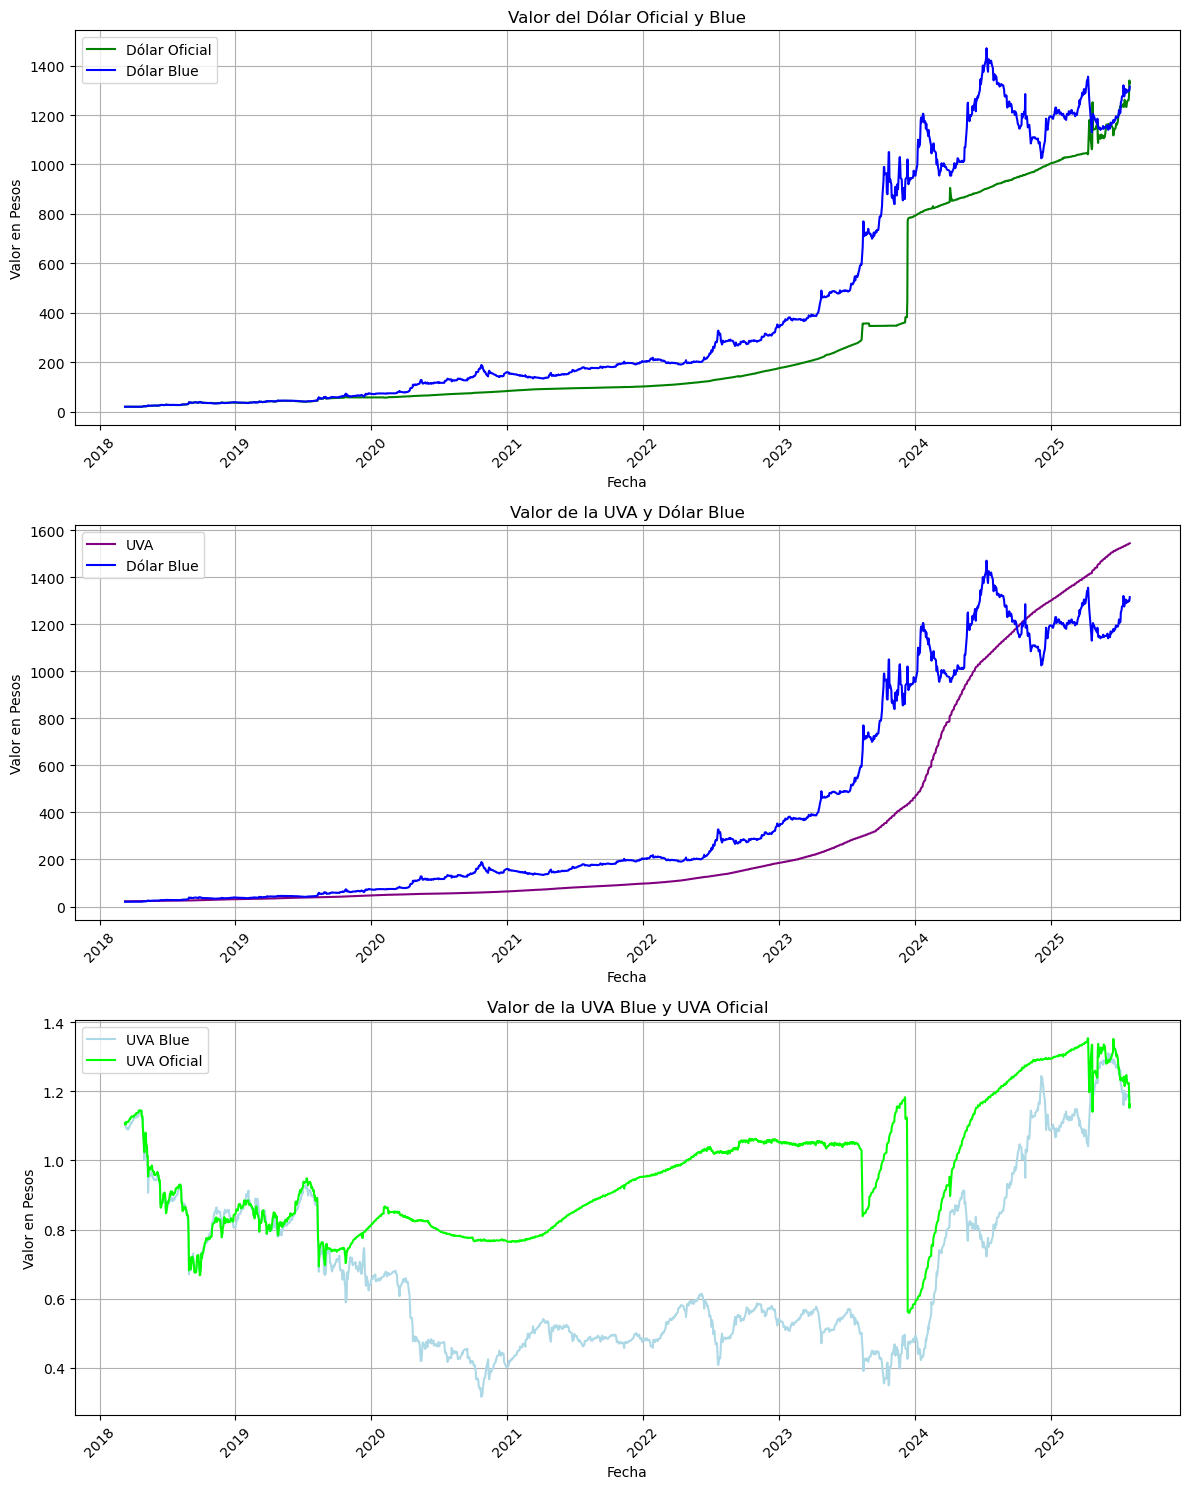

In [33]:
"""
Se grafica en una figura tres graficos
El primero con el valor del dolar oficial y el blue.
El segundo con el valor de la UVA y el valor del dolar blue
El tercero con el valor de la uva_blue y la uva_oficial
"""

fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Gráfico 1: Dólar Oficial y Blue
axs[0].plot(df["fecha"], df["usd_oficial"], label="Dólar Oficial", color="green")
axs[0].plot(df["fecha"], df["usd_blue"], label="Dólar Blue", color="blue")
axs[0].set_title("Valor del Dólar Oficial y Blue")
axs[0].set_xlabel("Fecha")
axs[0].set_ylabel("Valor en Pesos")
axs[0].legend()
# Gráfico 2: UVA y Dólar Blue
axs[1].plot(df["fecha"], df["uva"], label="UVA", color="purple")
axs[1].plot(df["fecha"], df["usd_blue"], label="Dólar Blue", color="blue")
axs[1].set_title("Valor de la UVA y Dólar Blue")
axs[1].set_xlabel("Fecha")
axs[1].set_ylabel("Valor en Pesos")
axs[1].legend()
# Gráfico 3: UVA Blue y UVA Oficial
axs[2].plot(df["fecha"], df["uva_blue"], label="UVA Blue", color="lightblue")
axs[2].plot(df["fecha"], df["uva_oficial"], label="UVA Oficial", color="lime")
axs[2].set_title("Valor de la UVA Blue y UVA Oficial")
axs[2].set_xlabel("Fecha")
axs[2].set_ylabel("Valor en Pesos")
axs[2].legend()
# Ajustes finales
for ax in axs:
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## Anaálisis Exploratorio de datos
Se procede a calcular las estadísticas descriptivas básicas de las series

In [34]:
"""Callculamos el valor promedio de la uva en dolares blue y oficial"""
uva_blue_mean = df["uva_blue"].mean()
uva_oficial_mean = df["uva_oficial"].mean()
print(f"Valor promedio de la UVA en dólares Blue: {uva_blue_mean:.2f}")
print(f"Valor promedio de la UVA en dólares Oficial: {uva_oficial_mean:.2f}")

Valor promedio de la UVA en dólares Blue: 0.69
Valor promedio de la UVA en dólares Oficial: 0.95


# Se analiza la posibilidad de estudiar estas series como modelos ARMA
### Elección de serie objetivo
Se procede a trabajar sobre la serie de uva medida en dólares blue.
Esto se debe a que hay perídos en donde la posibilidad de adquirir o vender esta divisa en el territorio, se puede medir verazmente solamente con el dólar blue.
## Planteo del modelo ARMA
Se intenta explicar esta serie como un proceso autoregresivo de orden p => AR(p)

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t,
\qquad \varepsilon_t \sim \mathcal{WN}(0,\sigma^2)
$$

ó como un moving average de orden q => MA(q)
$$
y_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q},
\qquad \varepsilon_t \sim \mathcal{WN}(0,\sigma^2)
$$


## Metodologia Box & Jenkins
4 pasos
1. Transformar las series para que sea estacionaria
    Para esto se toma la primer diferencia y evaluamos la estacionaridad


Estacionaridad de la UVA Blue:
ADF Statistic: -20.07855947369959
p-value: 0.0
La serie es estacionaria

Estacionaridad de la UVA Oficial:
ADF Statistic: -13.675416782679594
p-value: 1.4333730181211573e-25
La serie es estacionaria


Text(0.5, 0, 'Fecha')

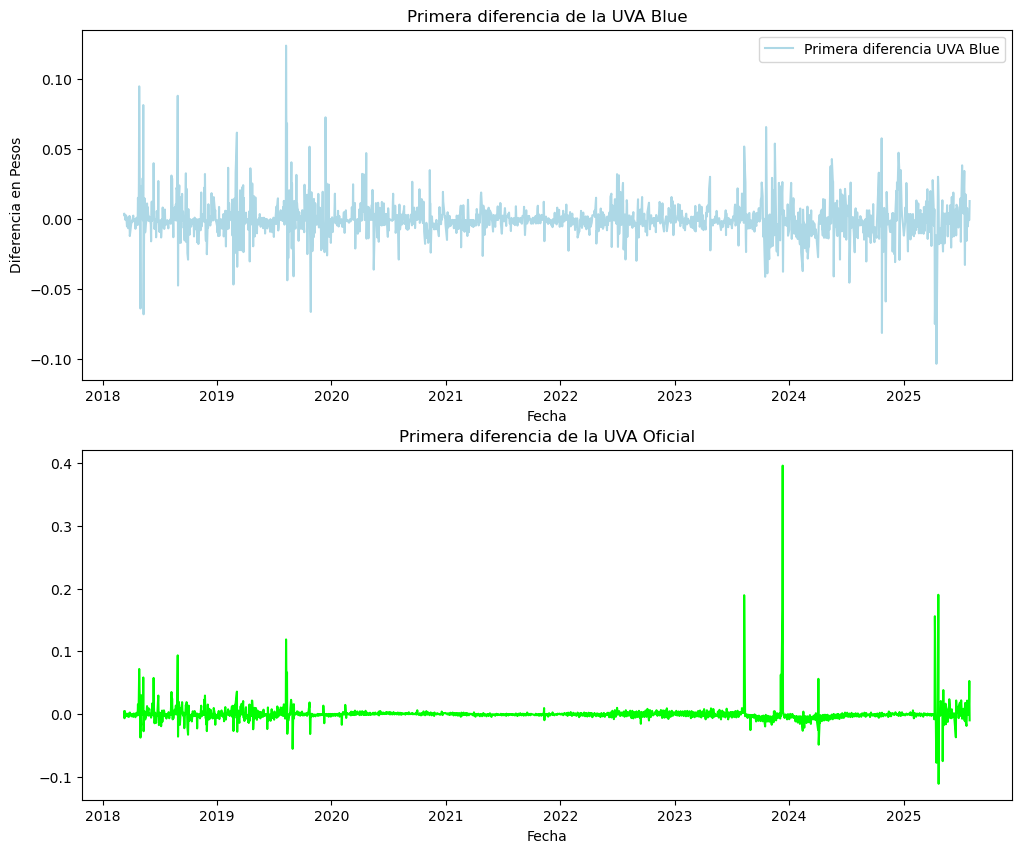

In [35]:
"""Cálculo de primeras diferencias"""
df["uva_blue_diff"] = df["uva_blue"].diff()
df["uva_oficial_diff"] = df["uva_oficial"].diff()
# Análisis de estacionaridad

def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("La serie es estacionaria")
    else:
        print("La serie no es estacionaria")
print("Estacionaridad de la UVA Blue:")
test_stationarity(df["uva_blue_diff"])
print("\nEstacionaridad de la UVA Oficial:")
test_stationarity(df["uva_oficial_diff"])

# Gráfico de las primeras diferencias
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(df["fecha"], df["uva_blue_diff"], label="Primera diferencia UVA Blue", color="lightblue")
axs[0].set_title("Primera diferencia de la UVA Blue")
axs[0].set_xlabel("Fecha")
axs[0].set_ylabel("Diferencia en Pesos")
axs[0].legend()
axs[1].plot(df["fecha"], df["uva_oficial_diff"], label="Primera diferencia UVA Oficial", color="lime")
axs[1].set_title("Primera diferencia de la UVA Oficial")
axs[1].set_xlabel("Fecha")

2. Ver el correlograma Representación gráfica de los valores del ACF y PACF

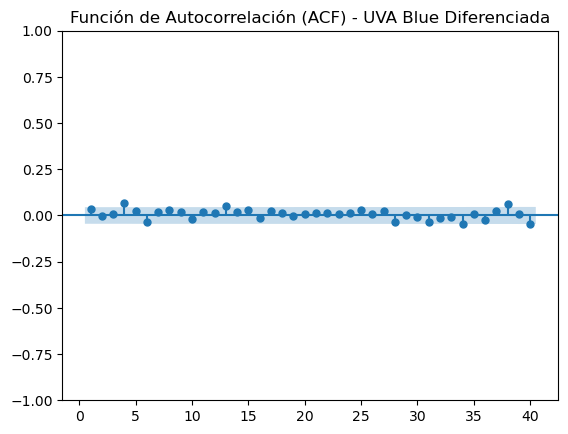

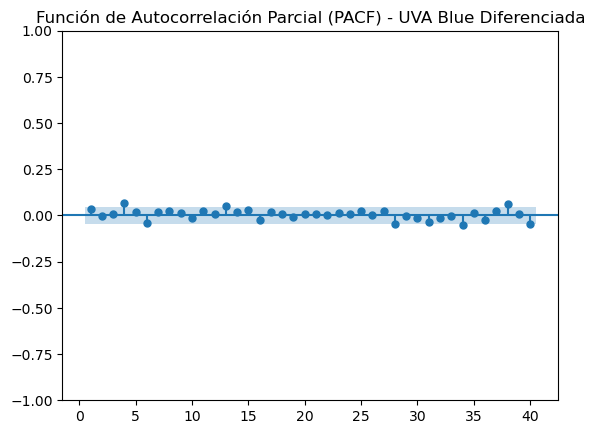

In [43]:
"""
Se evalúa los coeficientes de autocorrelación y autocorrelación parcial
con el método de Ljung-Box con statsmodels
"""
plot_acf(df["uva_blue_diff"].dropna(), lags=40, zero=False)
plt.title("Función de Autocorrelación (ACF) - UVA Blue Diferenciada")
plt.show()
plot_pacf(df["uva_blue_diff"].dropna(), lags=40, zero=False)
plt.title("Función de Autocorrelación Parcial (PACF) - UVA Blue Diferenciada")
plt.show()


3. Estimar un modelo ARMA 
    En este caso se observa que tnato la función de autocorrelación como la función de autocorrelación parcial no sugieren un modelo ARMA (p,q) válido. Por lo que se decide no estimar el modelo, ni analizar el correlograma de los residuos como sugiere la metodología de Box & Jenkins


## Explicación técnica y económica — por qué tiene sentido que ACF/PACF ≈ 0 en este caso

1. **La primera diferencia ≈ "retorno"**  
   - Para series de precios o ratios financieros (como `uva`, `uva_blue`, etc.), la primera diferencia se comporta análogamente a un *retorno*. En mercados relativamente informados, los retornos suelen ser **impredecibles** en la media: la mayor parte de la información nueva se incorpora inmediatamente al precio. Por eso la ACF/PACF sobre diferencias frecuentemente es ≈ 0.  

2. **Random walk y propiedad de incrementos no correlacionados**  
   - Si la serie de nivel sigue (aproximadamente) un paseo aleatorio con drift, sus incrementos son ruido blanco. Entonces es exactamente esperable que las autocorrelaciones en lags ≥ 1 sean ~0.  

3. **Alta frecuencia / micro-ruido y ajustes discretos**  
   - Cuando los datos son diarios o intradiarios hay mucho "ruido" (microestructura, ajuste de precios, spreads) que rompe correlaciones lineales pero deja la varianza con estructura (clustering de volatilidad). Resultado: ACF de la serie ≈ 0, pero ACF de los cuadrados puede ser significativo.  

4. **Cointegración en niveles no implica autocorrelación en diferencias**  
   - Dos series pueden estar cointegradas en niveles (largo plazo) y, sin embargo, sus **diferencias** ser ruido blanco. Esto es coherente con que el equilibrio de largo plazo exista pero las variaciones diarias alrededor de ese equilibrio sean impredecibles.  

5. **Efecto de tamaño muestral**  
   - Con muestras grandes, coeficientes minúsculos pueden resultar `statistically significant` aun si su magnitud económica es nula. La ACF/PACF cercana a cero sugiere que, aunque un test sobre un coeficiente puntual dé p<0.05, su impacto real es irrelevante para predicción.  

6. **Posibles rupturas estructurales / controles**  
   - En economías con cambios regulatorios frecuentes (controles de cambio, intervenciones), las relaciones lineales de corto plazo pueden romperse; el patrón observado (ACF~0) puede deberse a cambios de régimen que eliminan persistencia estacionaria simple.

---